# Quantum Machine Learning with Classiq

Welcome to the "Quantum Machine Learning with Classiq" tutorial. This guide is designed for users already familiar with the Classiq platform, aiming to explore the exciting realm of Quantum Machine Learning (QML) using Classiq. In this tutorial, we will cover three main methods to implement QML with Classiq:

1. **Using the VQE Primitive**
2. **Using the PyTorch Integration**
3. **Using the QSVM Built-in App**


Each section will provide a brief explanation of the method followed by a simple, illustrative example to demonstrate the integration. /
These examples are intended to be straightforward to help you get started quickly.

## Table of Contents

1. [Using the VQE Primitive](#Using-the-VQE-Primitive)
   - [Overview](#overview-vqe)
   - [Example Using Classiq](#Example-Using-Classiq)
   - [Summary & Exercise](#summary-exercise-vqe)
   - [Read More](#read-more-vqe)
2. [Using the PyTorch Integration](#Using-the-PyTorch-Integration)
   - [Overview](#overview-pytorch)
   - [Workflow](#Workflow)
   - [Example - Demonstrating PyTorch Integration with Classiq](#example-code-demonstrating-pytorch-integration-with-classiq)
   - [Step 1.1 - Define the quantum model and synthesize it into a quantum program](#step-11---define-the-quantum-model-and-synthesize-it-into-a-quantum-program)
   - [Step 1.2 - Define the Execute and Post-process callables](#step-12---define-the-execute-and-post-process-callables)
   - [Step 1.3 - Create a torch.nn.Module network](#step-13---create-a-torchnnmodule-network)
   - [Step 2 - Choose a dataset, loss function, and optimizer](#step-2---choose-a-dataset-loss-function-and-optimizer)
   - [Step 3 - Train & Evaluate](#step-3-train)
   - [Summary & Exercise](#summary-exercise-pytorch)
   - [Read More](#read-more-pytorch)
8. [Using QSVM Primitive](#Using-QSVM-Primitive)

## Using the VQE Primitive

### Overview <a id="overview-vqe"></a>

The Variational Quantum Eigensolver (VQE) is an algorithm used to find the lowest eigenvalue of a matrix. \
It follows these steps:

1. **Create a Parameterized Quantum Circuit**: Design a quantum circuit, also known as an ansatz, that captures the problem.
2. **Execute the Quantum Circuit**: Run the circuit to generate a quantum state.
3. **Estimate Values**: Measure the expected value of the matrix based on the state created by the circuit.
4. **Optimize Parameters**: Use a classical optimizer to adjust the circuit's parameters for better results.
5. **Repeat**: Continue this process until the algorithm converges to a solution or reaches a specified number of iterations.

### Example Using Classiq

Let's start with a simple example by creating a VQE algorithm that estimates the minimal eigenvalue of the following 2x2 matrix:

<body><center>
$ \begin{bmatrix} 1 & -1 \\ -1 & 0 \end{bmatrix} = \frac{1}{2}I + \frac{1}{2}Z - X $
</center><body>

Let's start with imports:

In [1]:
from typing import List

from classiq import *

Now, let's define the Hamiltonian of this 2x2 matrix using the Pauli matrices:

In [2]:
HAMILTONIAN = QConstant(
    "HAMILTONIAN",
    List[PauliTerm],
    [PauliTerm([Pauli.I], 0.5), PauliTerm([Pauli.Z], 0.5), PauliTerm([Pauli.X], -1)],
)

For a single qubit problem, using the U-gate (also known as the U3-gate) allows us to capture any rotation on the Bloch sphere. This includes the state with the minimal energy with respect to our Hamiltonian.

<details>
<summary> NOTE on U-gate</summary>
    
The single-qubit gate applies phase and rotation with three Euler angles.

Matrix representation:

$$
U(\gamma,\phi,\theta,\lambda) = e^{i\gamma}\begin{pmatrix}
\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda)}\cos(\frac{\theta}{2}) \\
\end{pmatrix}
$$

Parameters:

- `theta`: `CReal`
- `phi`: `CReal`
- `lam`: `CReal`
- `gam`: `CReal`
- `target`: `QBit`
</details>

In [3]:
@qfunc
def main(q: Output[QBit], angles: CArray[CReal, 3]) -> None:
    allocate(1, q)
    U(angles[0], angles[1], angles[2], 0, q)

To seamlessly harness the power of VQE, we will use a classical execution function called `cmain`. In our `cmain` function, we will specify that we are using the VQE primitive and initialize all the parameters:

In [4]:
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian=HAMILTONIAN,
        maximize=False,
        initial_point=[],  # Must be initialized for some optimizers
        optimizer=Optimizer.COBYLA,  # Constrained Optimization by Linear Approximation
        max_iteration=1000,
        tolerance=0.001,
        step_size=0,  # Must be initialized as none-zero value for some optimizers
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})

<details>
<summary> Supported Optimizers</summary>

- **ADAM**: Adam and AMSGRAD optimizers.
- **AQGD**: Analytic Quantum Gradient Descent (AQGD) with Epochs optimizer.
- **CG**: Conjugate Gradient optimizer.
- **COBYLA**: Constrained Optimization By Linear Approximation optimizer.
- **L_BFGS_B**: Limited-memory BFGS Bound optimizer.
- **GSLS**: Gaussian-smoothed Line Search.
- **GradientDescent**: The gradient descent minimization routine.
- **GradientDescentState**: State of GradientDescent.
- **NELDER_MEAD**: Nelder-Mead optimizer.
- **NFT**: Nakanishi-Fujii-Todo algorithm.
- **P_BFGS**: Parallelized Limited-memory BFGS optimizer.
- **POWELL**: Powell optimizer.
- **SLSQP**: Sequential Least SQuares Programming optimizer.
- **SPSA**: Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer.
- **QNSPSA**: The Quantum Natural SPSA (QN-SPSA) optimizer.
- **TNC**: Truncated Newton (TNC) optimizer.
- **SciPyOptimizer**: A general Qiskit Optimizer wrapping scipy.optimize.minimize.
- **UMDA**: Continuous Univariate Marginal Distribution Algorithm (UMDA).
</details>

Now let's create the model, specifying that we are using `classical_execution_function=cmain`:

In [5]:
qmod = create_model(main, classical_execution_function=cmain)
qprog = synthesize(qmod)

Executing from the Classiq Platform:

In [6]:
show(qprog)

Opening: https://platform.classiq.io/circuit/fc2a6eeb-dc3d-4264-8b61-6760ae2612bb?version=0.42.2


Or directly from the SDK:

In [7]:
res = execute(qprog)
# res.open_in_ide()
vqe_result = res.result()[0].value

Printing the final results:

In [8]:
print(f"Optimal energy: {vqe_result.energy}")
print(f"Optimal parameters: {vqe_result.optimal_parameters}")
print(f"Eigenstate: {vqe_result.eigenstate}")

Optimal energy: -0.6240234375
Optimal parameters: {'angles_0': 4.231154537560012, 'angles_1': 3.147445806511723, 'angles_2': 2.7306574045708336}
Eigenstate: {'0': (0.516334738808072+0j), '1': (0.856386850377795+0j)}


We can easily plot the `convergence_graph`:

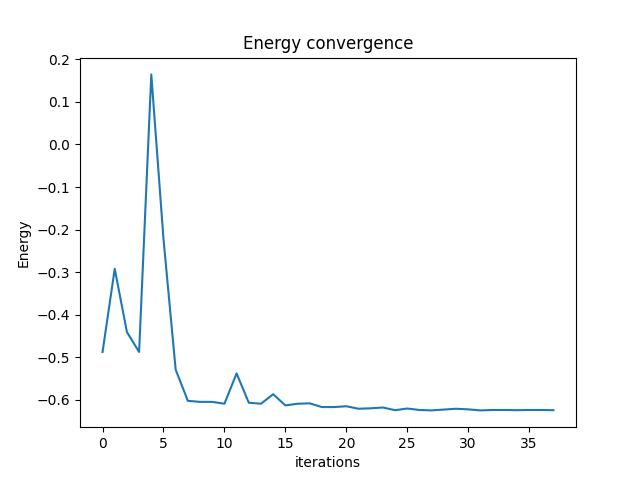

In [9]:
vqe_result.convergence_graph

### Summary & Exercise <a id="summary-exercise-vqe"></a>

We have designed a parameterized quantum circuit capable of capturing a simple Hamiltonian. We defined `cmain` as the classical execution function, including all necessary parameters for VQE execution, and plotted the results.


<details>
<summary>Exercise - Two Qubits VQE</summary>

Now we will practice the implementation of a similar case to the last example, but this time for two qubits, following the Hamiltonian:

$ H = \frac{1}{2}I \otimes I + \frac{1}{2}Z \otimes Z - X \otimes X $

**Use the last example to implement and execute VQE for this Hamiltonian**

Code Skeleton:

```python
HAMILTONIAN = QConstant("HAMILTONIAN", List[PauliTerm], [...]) #TODO: Complete Hamiltonian

@qfunc
def main(...) -> None:
    #TODO: Complete the function according to the instructions, choose simple ansatz.

@cfunc
def cmain() -> None:
    res = vqe(
        HAMILTONIAN,
        False,
        [],
        optimizer=Optimizer.COBYLA,
        max_iteration=1000,
        tolerance=0.001,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})

qmod = create_model(main, classical_execution_function=cmain)
qprog = synthesize(qmod)
show(qprog)
```
<details> 
<summary>Hint</summary>
QArray
</details>
</details>

### Read More <a id="read-more-vqe"></a>

- [Execution Primitives¶](https://docs.classiq.io/latest/reference-manual/platform/executor/primitives/#vqe)
- [Molecule Eigensolver](https://docs.classiq.io/latest/explore/applications/chemistry/molecule_eigensolver/molecule_eigensolver/)

## Using the PyTorch Integration

### Overview <a id="overview-pytorch"></a>

Classiq integrates with PyTorch, enabling the seamless development of quantum machine learning and hybrid classical-quantum machine learning models. This integration leverages PyTorch's powerful machine learning capabilities alongside quantum computing.

<details>
<summary>Note on PyTorch Installation</summary>

\
To properly install and run PyTorch locally, check [this page](https://pytorch.org/get-started/locally/)

</details>


### Workflow

1. **Model Definition**
    - **1.1**: Define the quantum model and synthesize it into a quantum program.
    - **1.2**: Define the execute and post-process callables.
    - **1.3**: Create a `torch.nn.Module` network.
2. **Choosing Dataset, Loss Function, and Optimizer**
3. **Training the Model**
4. **Testing the Model**


If you're not familiar with PyTorch, it is highly recommended to check out the following pages from their documentation:

<details>
<summary>PyTorch Documentation</summary>

- [Creating Models](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#creating-models)
- [Build the Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [Optimizing the Model Parameters](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
- [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
- [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

</details>


### Example - Demonstrating PyTorch integration with Classiq <a id="example-code-demonstrating-pytorch-integration-with-classiq"></a>

In this example, we will demonstrate the PyTorch integration using a simple parametric quantum circuit (PQC).

We will use one input from the user and one weight, while utilizing one qubit in the PQC. The goal of the learning process is to determine the correct angle for an RX gate to perform a "NOT" operation (spoiler: the correct answer is $\pi$).


Our data:

In [10]:
from classiq.applications.qnn.datasets import DATALOADER_NOT

for data, label in DATALOADER_NOT:
    print(f"--> Data for training:\n{data}")
    print(f"--> Corresponding labels:\n{label}")

--> Data for training:
tensor([[3.1416],
        [0.0000]])
--> Corresponding labels:
tensor([1., 0.])


#### Step 1.1 - Define the quantum model and synthesize it into a quantum program
<a id="step-11-define-the-quantum-model-and-synthesize-it-into-a-quantum-program"></a>

The first part of our PQC will have an encoding section, which is used to load input data ($|0\rangle$ or $|1\rangle$) into the PQC:


In [11]:
@qfunc
def encoding(theta: CReal, q: QArray[QBit]) -> None:
    RX(theta=theta, target=q[0])

The second part will be the `mixing` function, which will include an adjustable parameter for later training the RX gate to act as a NOT gate:

In [12]:
@qfunc
def mixing(theta: CReal, q: QArray[QBit]) -> None:
    RX(theta=theta, target=q[0])

Combining the two functions into our `main` function:

In [13]:
@qfunc
def main(input_0: CReal, weight_0: CReal, res: Output[QArray[QBit]]) -> None:
    allocate(1, res)
    encoding(theta=input_0, q=res)  # Loading input
    mixing(theta=weight_0, q=res)  # Adjustable parameter

Finally, create a model, synthesize it, and display it in the IDE:

In [14]:
model = create_model(main)
quantum_program = synthesize(model)
show(quantum_program)

Opening: https://platform.classiq.io/circuit/cfb19d54-e85d-4b8a-905b-9b809e8fab61?version=0.42.2


#### Step 1.2 - Define the Execute and Post-process callables

Before defining a quantum layer (QLayer), we need to define the `execute` and `post-processing` functions. These functions are necessary for integrating the quantum layer within a PyTorch neural network, as "classical layers" require classical data as input.

Imports:

In [15]:
import torch

from classiq.applications.qnn.types import (
    MultipleArguments,
    ResultsCollection,
    SavedResult,
)
from classiq.execution import execute_qnn
from classiq.synthesis import SerializedQuantumProgram

The `execute` function is a straightforward implementation of what we have just imported:

In [16]:
def execute(
    quantum_program: SerializedQuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    return execute_qnn(quantum_program, arguments)

The `post_process` function is used to process the result, returning the probability of measuring $|0\rangle$. This function assumes that we only care about differentiating a single state ($|0\rangle$) from all other states. If a different differentiation is needed, this function should be modified accordingly.

In [17]:
def post_process(result: SavedResult) -> torch.Tensor:
    """
    Take in a `SavedResult` with `ExecutionDetails` value type, and return the
    probability of measuring |0> which equals the amount of `|0>` measurements
    divided by the total amount of measurements.
    """
    counts: dict = result.value.counts
    # The probability of measuring |0>
    p_zero: float = counts.get("0", 0.0) / sum(counts.values())
    return torch.tensor(p_zero)

Using these functions allows QLayers and PyTorch layers to be properly integrated into the same neural network.

#### Step 1.3 - Create a torch.nn.Module network

Imports:

In [18]:
import torch

from classiq.applications.qnn import QLayer

And the `torch.nn.Module` class with a single QLayer:

In [19]:
class Net(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.qlayer = QLayer(
            quantum_program,  # the quantum program, the result of `synthesize()`
            execute,  # a callable that takes
            # - a quantum program
            # - parameters to that program (a tuple of dictionaries)
            # and returns a `ResultsCollection`
            post_process,  # a callable that takes
            # - a single `SavedResult`
            # and returns a `torch.Tensor`
            *args,
            **kwargs
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.qlayer(x)
        return x


model = Net()

In `self.qlayer = QLayer(...)`, we define the only layer in the neural network, a single QLayer. We specify the previously defined `quantum_program`, `execute`, and `post_process` as arguments for the layer. Finally, we create the neural network and assign it to the variable `model`.

#### Step 2 - Choose a dataset, loss function, and optimizer

Our dataset will be `DATALOADER_NOT` as defined [here](https://docs.classiq.io/latest/reference-manual/built-in-algorithms/qml/qnn/datasets/). For the loss function and optimizer, we will use [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), respectively.

Imports:

In [20]:
import torch.nn as nn
import torch.optim as optim

from classiq.applications.qnn.datasets import DATALOADER_NOT

In [21]:
_LEARNING_RATE = 1

# choosing our data
data_loader = DATALOADER_NOT

# choosing our loss function
loss_func = nn.L1Loss()  # Mean Absolute Error (MAE)

# choosing our optimizer
optimizer = optim.SGD(model.parameters(), lr=_LEARNING_RATE)

#### Step 3 - Train & Evaluate <a id="step-3-train"></a>

Importing `DataLoader`:

In [22]:
from torch.utils.data import DataLoader

A `DataLoader` in PyTorch efficiently iterates over datasets, handling batching, shuffling, and parallel data loading. It streamlines the process of training and evaluating models by managing data efficiently.

Now we are ready to define the training function. \
For this simple example, we will follow a similar loop to the one recommended by PyTorch [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#update-the-weights).


In [23]:
def train(
    model: nn.Module,
    data_loader: DataLoader,
    loss_func: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epoch: int = 1,  # About 40 Epochs need for full training
) -> None:
    for index in range(epoch):
        print(index, model.qlayer.weight)
        for data, label in data_loader:
            optimizer.zero_grad()

            output = model(data)

            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

In [24]:
train(model, data_loader, loss_func, optimizer)

0 Parameter containing:
tensor([0.4916], requires_grad=True)


Great! We can observe that our parameter is approximately equal to $\pi$. \
Now we will test our network accuracy using the suggested method [here](https://stackoverflow.com/questions/52176178/pytorch-model-accuracy-test#answer-64838681).

In [25]:
def check_accuracy(model: nn.Module, data_loader: DataLoader, atol=1e-4) -> float:
    num_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():  # Temporarily disable gradient calculation
        for data, labels in data_loader:
            # Let the model predict
            predictions = model(data)

            # Get a tensor of booleans, indicating if each label is close to the real label
            is_prediction_correct = predictions.isclose(labels, atol=atol)

            # Count the amount of `True` predictions
            num_correct += is_prediction_correct.sum().item()
            # Count the total evaluations
            #   the first dimension of `labels` is `batch_size`
            total += labels.size(0)

    accuracy = float(num_correct) / float(total)
    print(f"Test Accuracy of the model: {accuracy*100:.2f}%")
    return accuracy

In [26]:
check_accuracy(model, data_loader)

Test Accuracy of the model: 0.00%


0.0

**The results show an accuracy of 1**, indicating a 100% success rate in performing the required transformation (i.e., the network learned to perform an X-gate). We can further validate this by printing the value of `model.qlayer.weight`, which is a tensor of shape (1,1). After training, this value should be close to $\pi$.

### Summary & Exercise <a id="summary-exercise-pytorch"></a>

In this tutorial, we integrated a quantum layer within a PyTorch neural network, defined the necessary execution and post-processing functions, and trained the model using a simple dataset. We also tested the network's accuracy using a recommended method. To further explore, try experimenting with different quantum circuits, datasets, and optimizers. Intgreating more classic layers or more complex layers should be quite stright forword now for those who have some exprince with PyTorch.

<details>
<summary>Exercise - Training U Gate</summary>

Now for practice, try to implement a similar case to the last example, but this time train the U gate to act as a NOT gate, instead of the Rx gate.  
How many parameters will you have to train?  
What will you have to change to accomplish this?

<details>
<summary>Hint</summary>
    
You will have to adapt only `mixing` and `model`.

</details>
</details>


### Read More 
<a id="read-more-pytorch"></a>

- [QLayer](https://docs.classiq.io/latest/reference-manual/built-in-algorithms/qml/qnn/qlayer/)
- [QNNs with Classiq](https://docs.classiq.io/latest/reference-manual/built-in-algorithms/qml/qnn/qnn/)
- [QGAN](https://docs.classiq.io/latest/explore/algorithms/qml/qgan/qgan_bars_and_strips/)
- [Quantum Autoencoder](https://docs.classiq.io/latest/explore/algorithms/qml/quantum_autoencoder/quantum_autoencoder/)

## Using QSVM Primitive 

Classiq also enables executing classification tasks using the **Quantum Support Vector Machine** (QSVM) module. This module leverages the principles of quantum computing to enhance traditional support vector machine algorithms, offering significant improvements in classification accuracy and efficiency. The QSVM module integrates seamlessly with the Classiq platform, allowing users to implement quantum-enhanced classification models effortlessly. By utilizing quantum kernels, the QSVM can handle complex datasets and capture intricate patterns that may be challenging for classical SVMs, making it a powerful tool for various machine learning applications.



To understand how to use it and explore it further, check the following example: [QSVM with Classiq](https://docs.classiq.io/latest/explore/algorithms/qml/qsvm/qsvm/)